In [1]:
import pandas as pd   
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns
from sqlalchemy import create_engine, text
import psycopg2 
import shapely
from shapely.geometry import Point
from shapely.geometry import MultiPoint, Polygon
from shapely.geometry import MultiPolygon
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
#reading in listings data for nashvile
nash_list = pd.read_csv('../data/nashville_listings_sep23.csv')

In [4]:
nash_list.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6422.0,https://www.airbnb.com/rooms/6422,2.023090e+13,9/16/23,city scrape,Home in Nashville · ★4.95 · 1 bedroom · 1 bed ...,30 day plus rental - book for one month and th...,Historic East Nashville is home to many new an...,https://a0.muscache.com/pictures/miso/Hosting-...,12172,https://www.airbnb.com/users/show/12172,Michele,4/3/09,"Nashville, TN",My husband and I are parents of 5 grown childr...,NaN,NaN,0%,f,https://a0.muscache.com/im/users/12172/profile...,https://a0.muscache.com/im/users/12172/profile...,NaN,1,1,['phone'],t,t,"Nashville, Tennessee, United States",District 6,NaN,36.17143,-86.73570,Private room in home,Private room,1,NaN,1 private bath,NaN,1.0,"[""Cleaning products"", ""Private living room"", ""...",$43.00,30,365,30,30,365,365,30.0,365.0,NaN,t,0,0,0,227,9/16/23,674,0,0,4/30/09,3/3/20,4.95,4.94,4.96,4.97,4.96,4.92,4.98,NaN,f,1,0,1,0,3.85
1,39870.0,https://www.airbnb.com/rooms/39870,2.023090e+13,9/16/23,city scrape,Home in Nashville · ★4.94 · 1 bedroom · 1 bed ...,"Since I am older, I need for guests to be vacc...","The house is in a safe, quiet, ""college"" neig...",https://a0.muscache.com/pictures/miso/Hosting-...,171184,https://www.airbnb.com/users/show/171184,Evelyn,7/18/10,"Nashville, TN",I am a newly retired elementary school teacher...,within an hour,100%,95%,t,https://a0.muscache.com/im/users/171184/profil...,https://a0.muscache.com/im/users/171184/profil...,NaN,1,3,"['email', 'phone']",t,t,"Nashville, Tennessee, United States",District 25,NaN,36.12466,-86.81269,Private room in home,Private room,2,NaN,1 private bath,NaN,1.0,"[""Shower gel"", ""Hangers"", ""Portable fans"", ""Fr...",$70.00,1,1125,1,1,1125,1125,1.0,1125.0,NaN,t,15,30,60,212,9/16/23,401,73,8,9/16/16,9/12/23,4.94,4.95,4.94,4.98,4.98,4.94,4.94,NaN,f,1,0,1,0,4.70
2,59576.0,https://www.airbnb.com/rooms/59576,2.023090e+13,9/16/23,city scrape,Home in Nashville · 1 bedroom · 1 bed · 1 priv...,non-smokers only please<br /><br />furnished r...,We live on a cul-de-sac in a small community o...,https://a0.muscache.com/pictures/4e4e34db-3155...,812128,https://www.airbnb.com/users/show/812128,Patricia And John,7/12/11,NaN,Retired Military/ Realtor/Airline. Please cli...,within an hour,100%,98%,f,https://a0.muscache.com/im/users/812128/profil...,https://a0.muscache.com/im/users/812128/profil...,South Miami Heights,17,30,"['email', 'phone']",t,t,"Nashville, Tennessee, United States",District 12,NaN,36.18940,-86.59162,Private room in home,Private room,1,NaN,1 private bath,NaN,1.0,"[""Cleaning products"", ""Bidet"", ""Shower gel"", ""...",$45.00,30,365,30,30,365,365,30.0,365.0,NaN,t,29,59,89,89,9/16/23,2,0,0,6/26/22,9/14/22,4.50,5.00,3.50,5.00,5.00,5.00,

In [5]:
#review dates for nashville listings
nash_reviews = pd.read_csv('../data/nashville_reviews_sep23.csv')

In [6]:
nash_reviews.head()

,listing_id,date
0,6422,2009-04-30
1,3158038,2014-07-22
2,3158038,2014-08-04
3,3158038,2014-10-11
4,3158038,2015-03-22


In [7]:
#creating a geo data frame for nashville neighbourhoods
geo_file = "../data/nashville_neighbourhoodsgeo.geojson"

nash_gdf = gpd.read_file(geo_file)

In [8]:
nash_gdf.head()

,neighbourhood,neighbourhood_group,geometry
0,District 1,NaN,"MULTIPOLYGON (((-86.90738 36.39051, -86.90725 ..."
1,District 6,NaN,"MULTIPOLYGON (((-86.69743 36.20060, -86.69761 ..."
2,District 19,NaN,"MULTIPOLYGON (((-86.78203 36.18787, -86.78223 ..."
3,District 13,NaN,"MULTIPOLYGON (((-86.62522 36.15124, -86.62572 ..."
4,District 29,NaN,"MULTIPOLYGON (((-86.64001 36.12251, -86.63872 ..."


In [9]:
nash_gdf['district_num'] = nash_gdf['neighbourhood'].str.extract('(\d+)').astype(int)
nash_gdf.head()

,neighbourhood,neighbourhood_group,geometry,district_num
0,District 1,NaN,"MULTIPOLYGON (((-86.90738 36.39051, -86.90725 ...",1
1,District 6,NaN,"MULTIPOLYGON (((-86.69743 36.20060, -86.69761 ...",6
2,District 19,NaN,"MULTIPOLYGON (((-86.78203 36.18787, -86.78223 ...",19
3,District 13,NaN,"MULTIPOLYGON (((-86.62522 36.15124, -86.62572 ...",13
4,District 29,NaN,"MULTIPOLYGON (((-86.64001 36.12251, -86.63872 ...",29


In [10]:
nash_gdf = nash_gdf.drop(columns=['neighbourhood_group'])

In [11]:
nash_gdf.head()

,neighbourhood,geometry,district_num
0,District 1,"MULTIPOLYGON (((-86.90738 36.39051, -86.90725 ...",1
1,District 6,"MULTIPOLYGON (((-86.69743 36.20060, -86.69761 ...",6
2,District 19,"MULTIPOLYGON (((-86.78203 36.18787, -86.78223 ...",19
3,District 13,"MULTIPOLYGON (((-86.62522 36.15124, -86.62572 ...",13
4,District 29,"MULTIPOLYGON (((-86.64001 36.12251, -86.63872 ...",29


In [12]:
nash_gdf = nash_gdf.sort_values(by='district_num',ascending=True)

In [13]:
nash_gdf.head()

,neighbourhood,geometry,district_num
0,District 1,"MULTIPOLYGON (((-86.90738 36.39051, -86.90725 ...",1
6,District 2,"MULTIPOLYGON (((-86.75902 36.23091, -86.75909 ...",2
28,District 3,"MULTIPOLYGON (((-86.76842 36.38358, -86.76824 ...",3
17,District 4,"MULTIPOLYGON (((-86.74489 36.05316, -86.74491 ...",4
26,District 5,"MULTIPOLYGON (((-86.74725 36.21041, -86.74243 ...",5


In [14]:
nash_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

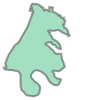

In [15]:
nash_gdf.loc[0, 'geometry']

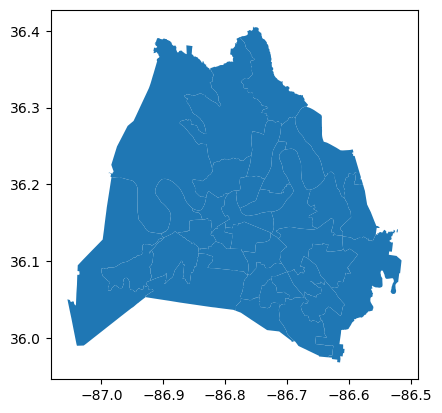

In [41]:
districts = nash_gdf.plot();

In [17]:
nash_list.head(1)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6422.0,https://www.airbnb.com/rooms/6422,2.023090e+13,9/16/23,city scrape,Home in Nashville · ★4.95 · 1 bedroom · 1 bed ...,30 day plus rental - book for one month and th...,Historic East Nashville is home to many new an...,https://a0.muscache.com/pictures/miso/Hosting-...,12172,https://www.airbnb.com/users/show/12172,Michele,4/3/09,"Nashville, TN",My husband and I are parents of 5 grown childr...,NaN,NaN,0%,f,https://a0.muscache.com/im/users/12172/profile...,https://a0.muscache.com/im/users/12172/profile...,NaN,1,1,['phone'],t,t,"Nashville, Tennessee, United States",District 6,NaN,36.17143,-86.7357,Private room in home,Private room,1,NaN,1 private bath,NaN,1.0,"[""Cleaning products"", ""Private living room"", ""...",$43.00,30,365,30,30,365,365,30.0,365.0,NaN,t,0,0,0,227,9/16/23,674,0,0,4/30/09,3/3/20,4.95,4.94,4.96,4.97,4.96,4.92,4.98,NaN,f,1,0,1,0,3.85


In [18]:
nash_list = nash_list.drop(columns=['listing_url','scrape_id','last_scraped','source','name','description','neighborhood_overview','picture_url','host_url','host_about','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_thumbnail_url','host_picture_url','host_verifications','host_has_profile_pic','host_identity_verified','neighbourhood_group_cleansed','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','calendar_last_scraped','license','instant_bookable','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms'])

In [19]:
nash_list.head()

,id,host_id,host_name,host_since,host_location,host_neighbourhood,host_listings_count,host_total_listings_count,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,6422.0,12172,Michele,4/3/09,"Nashville, TN",NaN,1,1,"Nashville, Tennessee, United States",District 6,36.17143,-86.73570,Private room in home,Private room,1,NaN,1 private bath,NaN,1.0,"[""Cleaning products"", ""Private living room"", ""...",$43.00,30,365,t,0,0,0,227,674,0,0,4/30/09,3/3/20,4.95,4.94,4.96,4.97,4.96,4.92,4.98,3.85
1,39870.0,171184,Evelyn,7/18/10,"Nashville, TN",NaN,1,3,"Nashville, Tennessee, United States",District 25,36.12466,-86.81269,Private room in home,Private room,2,NaN,1 private bath,NaN,1.0,"[""Shower gel"", ""Hangers"", ""Portable fans"", ""Fr...",$70.00,1,1125,t,15,30,60,212,401,73,8,9/16/16,9/12/23,4.94,4.95,4.94,4.98,4.98,4.94,4.94,4.70
2,59576.0,812128,Patricia And John,7/12/11,NaN,South Miami Heights,17,30,"Nashville, Tennessee, United States",District 12,36.18940,-86.59162,Private room in home,Private room,1,NaN,1 private bath,NaN,1.0,"[""Cleaning products"", ""Bidet"", ""Shower gel"", ""...",$45.00,30,365,t,29,59,89,89,2,0,0,6/26/22,9/14/22,4.50,5.00,3.50,5.00,5.00,5.00,5.00,0.13
3,72906.0,176117,Richard,7/21/10,"Nashville, TN",NaN,1,1,"Nashville, Tennessee, United States",District 18,36.13122,-86.80066,Entire rental unit,Entire home/apt,2,NaN,1 bath,2.0,2.0,"[""Hangers"", ""Patio or balcony"", ""First aid kit...",$119.00,2,7,t,2,17,47,47,702,44,3,6/9/11,9/3/23,4.91,4.90,4.82,4.98,4.99,4.97,4.89,4.70
4,258817.0,22296,Diana,6/19/09,"Nashville, TN",NaN,18,24,"Nashville, Tennessee, United States",District 12,36.16076,-86.59151,Private room in home,Private room,2,NaN,1 private bath,NaN,2.0,"[""Fireplace guards"", ""Hangers"", ""Indoor firepl...",$39.00,30,365,t,0,0,14,289,96,0,0,12/12/11,12/14/19,4.77,4.81,4.40,4.92,4.90,4.74,4.73,0.67


In [20]:
nash_list['host_location'].value_counts()

host_location
Nashville, TN       5124
Scottsdale, AZ       201
Sevierville, TN      149
New York, NY         104
Myrtle Beach, SC      84
                    ... 
Renton, WA             1
Buffalo, MN            1
Emeryville, CA         1
Bozeman, MT            1
Jericho, VT            1
Name: count, Length: 261, dtype: int64

In [21]:
room_type_counts = nash_list['room_type'].value_counts().reset_index()

In [22]:
room_type_counts

,room_type,count
0,Entire home/apt,7757
1,Private room,798
2,Hotel room,22
3,Shared room,7


<Figure size 1000x600 with 0 Axes>

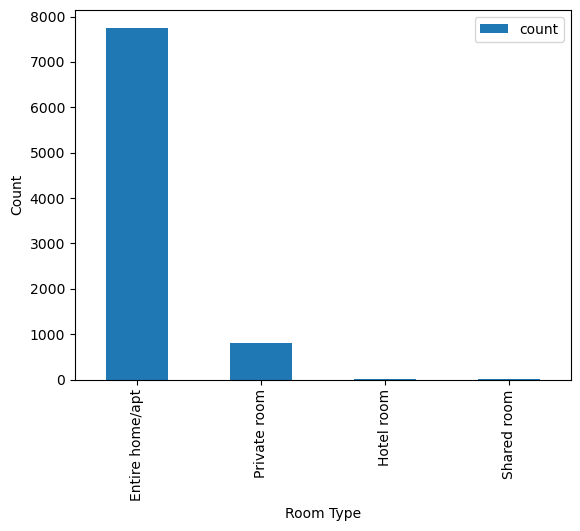

In [23]:
plt.figure(figsize=(10,6))
room_type_counts.plot(x='room_type', y='count', kind='bar')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.show()

In [24]:
host_listing_counts = nash_list['host_id'].value_counts().reset_index()
host_listing_counts

,host_id,count
0,101426897,207
1,20772148,197
2,134126657,149
3,85360355,134
4,115505661,99
...,...,...
3496,12515800,1
3497,36984634,1
3498,149778985,1
3499,21639697,1


In [25]:
nash_list['accommodates'].describe()

count    8584.000000
mean        6.886300
std         3.921534
min         1.000000
25%         4.000000
50%         6.000000
75%        10.000000
max        16.000000
Name: accommodates, dtype: float64

In [26]:
nash_list['price'].describe()

count        8584
unique        891
top       $80.00 
freq           72
Name: price, dtype: object

In [27]:
nash_list['price'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8584 entries, 0 to 8583
Series name: price
Non-Null Count  Dtype 
--------------  ----- 
8584 non-null   object
dtypes: object(1)
memory usage: 67.2+ KB


In [28]:
nash_list['price'] = nash_list['price'].str.replace('$', '').str.replace(',','').str.replace(' ', '').astype(float)

In [29]:
nash_list['price'].describe()

count     8584.000000
mean       277.843313
std       1034.252619
min         24.000000
25%        130.000000
50%        199.000000
75%        302.000000
max      90000.000000
Name: price, dtype: float64

In [30]:
nash_list.head()

,id,host_id,host_name,host_since,host_location,host_neighbourhood,host_listings_count,host_total_listings_count,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,6422.0,12172,Michele,4/3/09,"Nashville, TN",NaN,1,1,"Nashville, Tennessee, United States",District 6,36.17143,-86.73570,Private room in home,Private room,1,NaN,1 private bath,NaN,1.0,"[""Cleaning products"", ""Private living room"", ""...",43.0,30,365,t,0,0,0,227,674,0,0,4/30/09,3/3/20,4.95,4.94,4.96,4.97,4.96,4.92,4.98,3.85
1,39870.0,171184,Evelyn,7/18/10,"Nashville, TN",NaN,1,3,"Nashville, Tennessee, United States",District 25,36.12466,-86.81269,Private room in home,Private room,2,NaN,1 private bath,NaN,1.0,"[""Shower gel"", ""Hangers"", ""Portable fans"", ""Fr...",70.0,1,1125,t,15,30,60,212,401,73,8,9/16/16,9/12/23,4.94,4.95,4.94,4.98,4.98,4.94,4.94,4.70
2,59576.0,812128,Patricia And John,7/12/11,NaN,South Miami Heights,17,30,"Nashville, Tennessee, United States",District 12,36.18940,-86.59162,Private room in home,Private room,1,NaN,1 private bath,NaN,1.0,"[""Cleaning products"", ""Bidet"", ""Shower gel"", ""...",45.0,30,365,t,29,59,89,89,2,0,0,6/26/22,9/14/22,4.50,5.00,3.50,5.00,5.00,5.00,5.00,0.13
3,72906.0,176117,Richard,7/21/10,"Nashville, TN",NaN,1,1,"Nashville, Tennessee, United States",District 18,36.13122,-86.80066,Entire rental unit,Entire home/apt,2,NaN,1 bath,2.0,2.0,"[""Hangers"", ""Patio or balcony"", ""First aid kit...",119.0,2,7,t,2,17,47,47,702,44,3,6/9/11,9/3/23,4.91,4.90,4.82,4.98,4.99,4.97,4.89,4.70
4,258817.0,22296,Diana,6/19/09,"Nashville, TN",NaN,18,24,"Nashville, Tennessee, United States",District 12,36.16076,-86.59151,Private room in home,Private room,2,NaN,1 private bath,NaN,2.0,"[""Fireplace guards"", ""Hangers"", ""Indoor firepl...",39.0,30,365,t,0,0,14,289,96,0,0,12/12/11,12/14/19,4.77,4.81,4.40,4.92,4.90,4.74,4.73,0.67


In [31]:
room_price = nash_list[['price','room_type']]
room_price

,price,room_type
0,43.0,Private room
1,70.0,Private room
2,45.0,Private room
3,119.0,Entire home/apt
4,39.0,Private room
...,...,...
8579,255.0,Private room
8580,255.0,Private room
8581,321.0,Entire home/apt
8582,157.0,Entire home/apt


In [32]:
nash_list.groupby('room_type')['price'].mean()

room_type
Entire home/apt    287.935284
Hotel room         253.227273
Private room       181.279449
Shared room        180.142857
Name: price, dtype: float64

In [33]:
nash_list.head(1)

,id,host_id,host_name,host_since,host_location,host_neighbourhood,host_listings_count,host_total_listings_count,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,6422.0,12172,Michele,4/3/09,"Nashville, TN",NaN,1,1,"Nashville, Tennessee, United States",District 6,36.17143,-86.7357,Private room in home,Private room,1,NaN,1 private bath,NaN,1.0,"[""Cleaning products"", ""Private living room"", ""...",43.0,30,365,t,0,0,0,227,674,0,0,4/30/09,3/3/20,4.95,4.94,4.96,4.97,4.96,4.92,4.98,3.85


In [34]:
nash_trimmed = nash_list.loc[nash_list['number_of_reviews']>50]

In [35]:
nash_trimmed

,id,host_id,host_name,host_since,host_location,host_neighbourhood,host_listings_count,host_total_listings_count,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,6.422000e+03,12172,Michele,4/3/09,"Nashville, TN",NaN,1,1,"Nashville, Tennessee, United States",District 6,36.171430,-86.735700,Private room in home,Private room,1,NaN,1 private bath,NaN,1.0,"[""Cleaning products"", ""Private living room"", ""...",43.0,30,365,t,0,0,0,227,674,0,0,4/30/09,3/3/20,4.95,4.94,4.96,4.97,4.96,4.92,4.98,3.85
1,3.987000e+04,171184,Evelyn,7/18/10,"Nashville, TN",NaN,1,3,"Nashville, Tennessee, United States",District 25,36.124660,-86.812690,Private room in home,Private room,2,NaN,1 private bath,NaN,1.0,"[""Shower gel"", ""Hangers"", ""Portable fans"", ""Fr...",70.0,1,1125,t,15,30,60,212,401,73,8,9/16/16,9/12/23,4.94,4.95,4.94,4.98,4.98,4.94,4.94,4.70
3,7.290600e+04,176117,Richard,7/21/10,"Nashville, TN",NaN,1,1,"Nashville, Tennessee, United States",District 18,36.131220,-86.800660,Entire rental unit,Entire home/apt,2,NaN,1 bath,2.0,2.0,"[""Hangers"", ""Patio or balcony"", ""First aid kit...",119.0,2,7,t,2,17,47,47,702,44,3,6/9/11,9/3/23,4.91,4.90,4.82,4.98,4.99,4.97,4.89,4.70
4,2.588170e+05,22296,Diana,6/19/09,"Nashville, TN",NaN,18,24,"Nashville, Tennessee, United States",District 12,36.160760,-86.591510,Private room in home,Private room,2,NaN,1 private bath,NaN,2.0,"[""Fireplace guards"", ""Hangers"", ""Indoor firepl...",39.0,30,365,t,0,0,14,289,96,0,0,12/12/11,12/14/19,4.77,4.81,4.40,4.92,4.90,4.74,4.73,0.67
5,2.892420e+05,22296,Diana,6/19/09,"Nashville, TN",NaN,18,24,"Nashville, Tennessee, United States",District 12,36.162960,-86.591130,Private room in home,Private room,1,NaN,1 shared bath,NaN,3.0,"[""Hangers"", ""Indoor fireplace"", ""Kitchen"", ""Fr...",33.0,30,365,t,15,45,75,350,76,0,0,12/28/11,1/12/19,4.71,4.75,4.27,4.83,4.78,4.47,4.69,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7083,8.501790e+17,62958099,Julia,3/14/16,"Hopatcong, NJ",Downtown,1,1,"Nashville, Tennessee, United States",District 19,36.153659,-86.775186,Entire rental unit,Entire home/apt,4,NaN,1 bath,1.0,1.0,"[""Shower gel"", ""Free washer \u2013 In unit"", ""...",164.0,1,365,t,0,2,17,261,55,55,10,4/2/23,9/13/23,4.87,4.89,4.87,4.51,4.89,4.78,4.80,9.82
7172,8.535540e+17,157362828,Ron & Susan,11/4/17,"Kentucky, United States",Midtown,10,12,"Nashville, Tennessee, United States",District 19,36.144589,-86.795256,Entire rental unit,Entire home/apt,6,NaN,1.5 baths,2.0,3.0,"[""Cleaning products"", ""Free washer \u2013 In u...",133.0,2,1125,t,2,5,9,143,56,56,10,4/19/23,9/14/23,4.96,4.96,4.96,4.98,4.96,4.95,4.93,11.13
7298,8.674230e+17,239175383,Locale,1/26/19,"Austin, TX",Edgehill,50,52,"Nashville, Tennessee, United States",District 6,36.176281,-86.755552,Room in aparthotel,Entire home/apt,6,NaN,2 baths,2.0,3.0,"[""Cleaning products"", ""Shower gel"", ""Free wash...",239.0,1,365,t,26,56,86,100,53,53,1,4/22/23,9/4/23,4.66,4.81,4.79,4.75,4.89,4.72,4.66,10.74
7395,8.784410e+17,133757060,Zac,6/6/17,"Nashville, TN",Watkins Park,8,10,"Nashville, Tennessee, United States",District 19,36.163840,-86.784410,Entire rental unit,Entire home/apt,6,NaN,1 bath,2.0,6.0,"[""Cleaning products"", ""Shower gel"", ""Hangers"",...",336.0,1,365,t,10,25,53,148,53,53,8,5/5/23,9/13/23,4.92,4.92,4.96,4.96,4.94,4.94,4.77,11.78


In [37]:
nash_list.shape

(8584, 41)

In [38]:
nash_trimmed.shape

(3145, 41)

In [39]:
nash_list.to_excel('../data/nash_listings.xlsx', index=False)

In [40]:
nash_trimmed.to_excel('../data/nash_trimmed.xlsx', index=False)